In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import  confusion_matrix
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score 
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from joblib import dump, load

df = pd.read_csv(r'../ABT_PROD_TRAINING_DATASET.csv', sep=';', encoding = 'windows-1251')

df = df.set_index(['CLIENT_ID'])

In [4]:
df.dtypes

Target                      int64
AGE                       float64
CHILDREN_CNT              float64
EDUCATION                  object
CLIENT_INCOME_AMT         float64
IS_CAR_FLG                 object
ADD_INCOME_AMT            float64
CARD_CUR_CNT                int64
REMN_PAYMENT_CNT          float64
LOAN_DAY_CNT              float64
LAST_CRD_OPEN_MNTH_CNT    float64
TR_MBANLOG_CNT_Q2           int64
MAX_CREDIT_REST_HY2       float64
CUR_DEP_AMT               float64
CUR_CREDIT_AMT            float64
dtype: object

In [3]:
df['Target'].value_counts()

0    300000
1     70914
Name: Target, dtype: int64

In [4]:
def divide_by_steps(dataframe, col_name, step = 5, aftermax = 80):
    
    t = step

    dataframe.loc[((dataframe[col_name]<0),col_name)]=0

    while(step<= aftermax * 2):
        dataframe.loc[((dataframe[col_name]> step - t) & (dataframe[col_name]<= step),col_name)]= step
        step += t

    dataframe.loc[((dataframe[col_name]>=aftermax),col_name)]=aftermax
    return dataframe

def iv_woe(data, target, bins=10, show_woe=False):
    newDF, woeDF = pd.DataFrame(), pd.DataFrame()
    cols = data.columns
    
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars])) > 10):
            binned_x = pd.qcut(data[ivars], bins, duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events'] / d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(), 3)))
        temp = pd.DataFrame({"Variable": [ivars], "IV": [d['IV'].sum()]}, columns=["Variable", "IV"])
        
        d.drop(['% of Non-Events', 'Non-Events', '% of Events'], axis=1, inplace=True)
        newDF = pd.concat([newDF, temp], axis=0)
        woeDF = pd.concat([woeDF, d], axis=0)

        if show_woe:
            print(d)
    return woeDF

def plot_woe(df, bins=10, column='AGE'):
    woe = iv_woe(data=df[['Target', column]], target='Target', bins=10, show_woe=True)
    woe = woe.loc[:, ['Cutoff', 'WoE']]

    plt.figure(figsize=(12, 10))
    plt.plot(woe.index, woe['WoE'], marker='o')
    plt.axhline(0, color='red', linestyle='--', linewidth=1)
    plt.xlabel('Categories')
    plt.ylabel('Weight of Evidence (WoE)')
    plt.title(f'WoE for Column: {column}')
    plt.grid(True)

    for i, label in enumerate(woe['Cutoff']):
        plt.annotate(label, (woe.index[i], woe['WoE'][i]), textcoords="offset points", xytext=(0, 10), ha='left')

    plt.show()

# Calculate information value
def calc_iv(df, feature, target, pr=0):

    lst = []

    for i in range(df[feature].nunique()):
        
        val = list(df[feature].unique())[i]
        lst.append([feature, val, df[df[feature] == val].count()[feature], df[(df[feature] == val) & (df[target] == 1)].count()[feature]])

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Bad'])
    data = data[data['Bad'] > 0]

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])
    data['IV'] = (data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])).sum()

    data = data.sort_values(by=['Variable', 'Value'], ascending=True)

    if pr == 1:
        print(data)

    return data['IV'].values[0]

In [26]:
df.columns

Index(['Target', 'OTHER_CAMP_CNT_M0', 'CALL_RESP_NEG_CNT_M2',
       'MAX_CREDIT_REST_HY2', 'TR_ATM_MAX_Y1', 'REPAY_LAST_Y_FLG',
       'FACT_PAYMENT_CNT', 'ADD_INCOME_AMT', 'DPND_CNT', 'FMEMB_CNT',
       'CLIENT_INCOME_AMT_450000', 'LAST_CRD_OPEN_MNTH_CNT_40.0',
       'LOAN_AGR_DAY_PCT_50', 'TR_LAST_WDRAW_DAYS_CNT_30', 'CALL_CNT_HY2_2',
       'TR_MBANLOG_CNT_M0_10'],
      dtype='object')

# EDA Analysis

In [7]:
corr_df = pd.DataFrame(df.corr()['Target'])
corr_df = corr_df.reset_index()

low_correlation_features = []
nan_features = []

for i in corr_df[(corr_df['Target'] < 0.2)]['index']:
    low_correlation_features.append(i)
    
for i in corr_df[pd.isna(corr_df['Target'])]['index']:
    nan_features.append(i)

df.drop(low_correlation_features, axis=1, inplace=True)
df.drop(nan_features, axis=1, inplace=True)

In [5]:
df_corr = df.corr()['Target'].sort_values(ascending = False)

pd.options.display.max_rows = 4000
print(df_corr)
print(df.shape)

Target                    1.000000
REMN_PAYMENT_CNT          0.368616
CARD_CUR_CNT              0.332490
TR_MBANLOG_CNT_Q2         0.252271
CUR_CREDIT_AMT            0.207656
MAX_CREDIT_REST_HY2       0.171875
CHILDREN_CNT              0.135505
ADD_INCOME_AMT            0.052231
CLIENT_INCOME_AMT         0.050830
CUR_DEP_AMT              -0.013074
AGE                      -0.184271
LAST_CRD_OPEN_MNTH_CNT   -0.256435
LOAN_DAY_CNT             -0.265402
Name: Target, dtype: float64
(370914, 15)


In [9]:
df.isna().sum()

Target                     0
AGE                        0
CHILDREN_CNT               0
EDUCATION              87727
CLIENT_INCOME_AMT          0
IS_CAR_FLG                 0
ADD_INCOME_AMT             0
CARD_CUR_CNT               0
REMN_PAYMENT_CNT           0
LOAN_DAY_CNT               0
TR_MBANLOG_CNT_Q2          0
MAX_CREDIT_REST_HY2        0
CUR_DEP_AMT                0
CUR_CREDIT_AMT             0
dtype: int64

In [35]:
def df_transformation(df):
    
    df.loc[df['IS_CAR_FLG']=='Y','IS_CAR_FLG']='1'
    df.loc[df['IS_CAR_FLG']=='N','IS_CAR_FLG']='0'
    df.loc[df['IS_CAR_FLG']=='1','IS_CAR_FLG']=1
    df.loc[df['IS_CAR_FLG']=='0','IS_CAR_FLG']=0

    df['IS_CAR_FLG'] = pd.to_numeric(df['IS_CAR_FLG'])
    
    df.drop(['LAST_CRD_OPEN_MNTH_CNT'], axis = 1, inplace = True)
    df['AGE'].fillna(value = df['AGE'].mean(), inplace = True)
    df['CHILDREN_CNT'].fillna(value = 0, inplace = True)
    df['CLIENT_INCOME_AMT'].fillna(value = 0, inplace = True)
    df['ADD_INCOME_AMT'].fillna(value = 0, inplace = True)
    df['MAX_CREDIT_REST_HY2'].fillna(value = 0, inplace = True)
    df['CUR_DEP_AMT'].fillna(value = 0, inplace = True)
    df['CUR_CREDIT_AMT'].fillna(value = 0, inplace = True)
    
    df = pd.get_dummies(df, columns=['EDUCATION'])
    
    #df.drop(['EDUCATION_Среднее', 'EDUCATION_Начальное общее', 'EDUCATION_Начальное профессиональное', 'EDUCATION_Общее среднее',
    #     'EDUCATION_Незаконченное высшее', 'EDUCATION_Основное среднее', 'EDUCATION_Техническое'], axis = 1, inplace = True)
    
    df.loc[((df['AGE']>=75) ,'AGE')]=75
    df.loc[((df['AGE']<=18) ,'AGE')]=18

    df.loc[((df['ADD_INCOME_AMT']<90000),'ADD_INCOME_AMT')]=0
    df.loc[((df['ADD_INCOME_AMT']>=90000) ,'ADD_INCOME_AMT')]='>=90000'

    df.loc[((df['CLIENT_INCOME_AMT']<260000),'CLIENT_INCOME_AMT')]=0
    df.loc[((df['CLIENT_INCOME_AMT']>=260000) ,'CLIENT_INCOME_AMT')]='>=260000'

    df.loc[((df['MAX_CREDIT_REST_HY2']<86000),'MAX_CREDIT_REST_HY2')]=0
    df.loc[((df['MAX_CREDIT_REST_HY2']>=86000) ,'MAX_CREDIT_REST_HY2')]='>=86000'

    df.loc[((df['CUR_CREDIT_AMT']<350000),'CUR_CREDIT_AMT')]=0
    df.loc[((df['CUR_CREDIT_AMT']>=350000) ,'CUR_CREDIT_AMT')]='>=350000'

    df.loc[((df['CARD_CUR_CNT']<=1),'CARD_CUR_CNT')]=1
    df.loc[((df['CARD_CUR_CNT']>1),'CARD_CUR_CNT')]='>=2'
    
    df = pd.get_dummies(df, columns=['ADD_INCOME_AMT', 'CLIENT_INCOME_AMT', 'CARD_CUR_CNT', 'MAX_CREDIT_REST_HY2',
                                 'CUR_CREDIT_AMT'])
    
    #df = df.drop(['CLIENT_INCOME_AMT_0.0', 'ADD_INCOME_AMT_0.0', 'CARD_CUR_CNT_1', 'REMN_PAYMENT_CNT',
    #          'LOAN_DAY_CNT', 'TR_MBANLOG_CNT_Q2', 'CUR_DEP_AMT', 'CUR_CREDIT_AMT_0.0', 'MAX_CREDIT_REST_HY2_0.0', 
    #              'IS_CAR_FLG'], axis = 1)
    
    df = df[['CLIENT_ID', 'Target', 'AGE', 'CHILDREN_CNT', 'EDUCATION_Высшее',
       'ADD_INCOME_AMT_>=90000', 'CLIENT_INCOME_AMT_>=260000',
       'CARD_CUR_CNT_>=2', 'MAX_CREDIT_REST_HY2_>=86000',
       'CUR_CREDIT_AMT_>=350000']]
    
    return df
    

In [7]:
df = df_transformation(df)

In [13]:
df.columns

Index(['Target', 'AGE', 'CHILDREN_CNT', 'EDUCATION_Высшее',
       'ADD_INCOME_AMT_>=90000', 'CLIENT_INCOME_AMT_>=260000',
       'CARD_CUR_CNT_>=2', 'MAX_CREDIT_REST_HY2_>=86000',
       'CUR_CREDIT_AMT_>=350000'],
      dtype='object')

# Model training

In [32]:
df_corr = df.corr()['Target'].sort_values(ascending = False)

pd.options.display.max_rows = 4000
print(df_corr)
print(df.shape)

Target                         1.000000
CUR_CREDIT_AMT_>=350000        0.289092
CARD_CUR_CNT_>=2               0.245574
CLIENT_INCOME_AMT_>=260000     0.244255
MAX_CREDIT_REST_HY2_>=86000    0.224660
ADD_INCOME_AMT_>=90000         0.176245
CHILDREN_CNT                   0.135495
EDUCATION_Высшее               0.128730
AGE                           -0.184405
Name: Target, dtype: float64
(370914, 9)


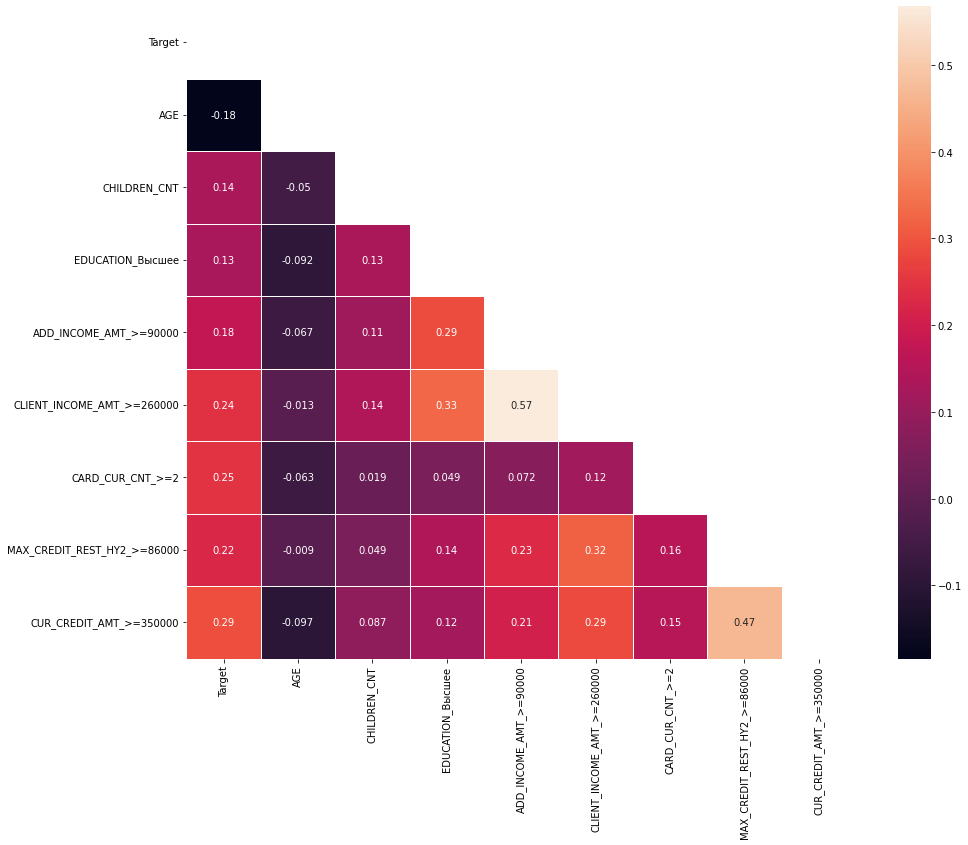

In [33]:
plt.figure(figsize=(15, 12))
matrix = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True,linewidth=.8, mask=matrix, cmap="rocket");

In [20]:
for i in df.columns: print(str(i) + ' ' + '%.5f' % calc_iv(df, i, 'Target'))

Target 0.00000
AGE 0.31566
CHILDREN_CNT inf
IS_CAR_FLG 0.00204


C:\Users\DAytkali\AppData\Roaming\Python\Python39\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


EDUCATION_Высшее 0.10979
ADD_INCOME_AMT_>=90000 0.18716
CLIENT_INCOME_AMT_>=260000 0.40559
CARD_CUR_CNT_>=2 0.28709
MAX_CREDIT_REST_HY2_>=86000 0.27232
CUR_CREDIT_AMT_>=350000 0.41412


In [194]:
list(df.columns)

['Target',
 'AGE',
 'CHILDREN_CNT',
 'IS_CAR_FLG',
 'EDUCATION_Высшее',
 'ADD_INCOME_AMT_>=90000',
 'CLIENT_INCOME_AMT_>=260000',
 'CARD_CUR_CNT_>=2',
 'MAX_CREDIT_REST_HY2_>=86000',
 'CUR_CREDIT_AMT_>=350000']

# Classifier

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370914 entries, 9529273 to 63109545
Data columns (total 9 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Target                       370914 non-null  int64  
 1   AGE                          370914 non-null  float64
 2   CHILDREN_CNT                 370914 non-null  float64
 3   EDUCATION_Высшее             370914 non-null  uint8  
 4   ADD_INCOME_AMT_>=90000       370914 non-null  uint8  
 5   CLIENT_INCOME_AMT_>=260000   370914 non-null  uint8  
 6   CARD_CUR_CNT_>=2             370914 non-null  uint8  
 7   MAX_CREDIT_REST_HY2_>=86000  370914 non-null  uint8  
 8   CUR_CREDIT_AMT_>=350000      370914 non-null  uint8  
dtypes: float64(2), int64(1), uint8(6)
memory usage: 13.4 MB


In [204]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import RandomUnderSampler

x = df.drop('Target',axis=1)
y = df[['Target']]

rus = RandomUnderSampler(random_state=42)
x_res, y_res = rus.fit_resample(x, y)
x_res.index = x.index[rus.sample_indices_]
y_res.index = y.index[rus.sample_indices_]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

rus = RandomUnderSampler(random_state=42)
x_res, y_res = rus.fit_resample(x_train, y_train)
x_res.index = x_train.index[rus.sample_indices_]
y_res.index = y_train.index[rus.sample_indices_]

x_train = x_res
y_train = y_res

#x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [35]:
df.describe()

,Target,AGE,CHILDREN_CNT,EDUCATION_Высшее,ADD_INCOME_AMT_>=90000,CLIENT_INCOME_AMT_>=260000,CARD_CUR_CNT_>=2,MAX_CREDIT_REST_HY2_>=86000,CUR_CREDIT_AMT_>=350000
count,370914.000000,370914.000000,370914.000000,370914.000000,370914.000000,370914.000000,370914.000000,370914.000000,370914.000000
mean,0.191187,43.827453,0.578212,0.510293,0.309185,0.469335,0.072019,0.175518,0.118232
std,0.393237,13.747420,1.031465,0.499895,0.462158,0.499059,0.258520,0.380410,0.322883
min,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,42.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,54.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,75.000000,16.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


100%|██████████| 1000/1000 [11:26<00:00,  1.46epoch/s, Loss=0.3987]


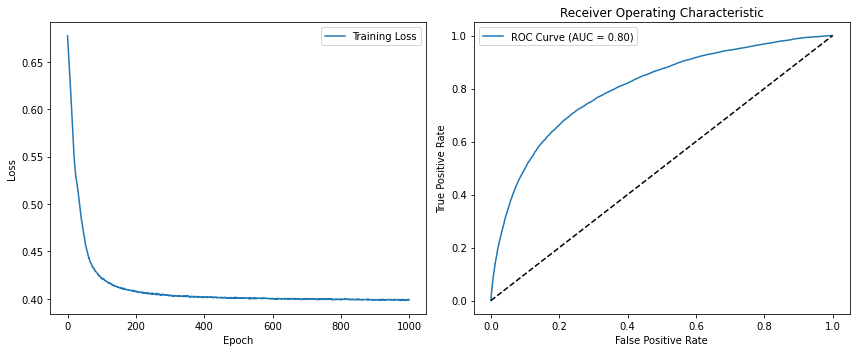

Accuracy: 0.8347
F1 Score: 0.4256
ROC AUC: 0.8028


In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# Load and preprocess your data
# df = pd.read_csv('your_dataset.csv')
X = df.drop('Target', axis=1).values
y = df['Target'].values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Select numerical features for normalization
numerical_features = [0, 1]  # Replace with the column indices of numerical features

# Apply standard scaling to numerical features
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[:, numerical_features] = scaler.fit_transform(X_train[:, numerical_features])
X_test_scaled[:, numerical_features] = scaler.transform(X_test[:, numerical_features])

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# ... Rest of the code remains the same ...


# Define the neural network architecture
class DeepNeuralNetwork(nn.Module):
    def __init__(self, input_size, dropout_rate=0.5, weight_decay=0.001):
        super(DeepNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.output_layer = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.weight_decay = weight_decay

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.relu(self.layer3(x))
        x = self.dropout(x)
        x = self.sigmoid(self.output_layer(x))
        return x

input_size = X_train.shape[1]
model = DeepNeuralNetwork(input_size=X_train.shape[1], dropout_rate=0.5, weight_decay=0.001)


# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# Training loop
num_epochs = 1000
train_losses = []
best_f1 = 0.0 
best_model_state = None

progress_bar = tqdm(range(num_epochs), unit="epoch")

for epoch in progress_bar:
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.view(-1, 1))
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    # Update the tqdm progress bar
    progress_bar.set_postfix({"Loss": f"{loss.item():.4f}"})

# Testing and evaluation
with torch.no_grad():
    model.eval()
    y_pred_prob = model(X_test_tensor)
    y_pred = (y_pred_prob >= 0.5).float()
    val_f1 = f1_score(y_test, y_pred)
    
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_model_state = model.state_dict().copy()
    
    progress_bar.set_postfix({"Loss": f"{loss.item():.4f}", "Val F1": f"{val_f1:.4f}"})

    
if best_model_state is not None:
    model.load_state_dict(best_model_state)   

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# ROC-AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_curve = auc(fpr, tpr)

# Visualize losses and metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_curve:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


In [ ]:
if best_model_state is not None:
    model.load_state_dict(best_model_state)   

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# ROC-AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_curve = auc(fpr, tpr)

# Visualize losses and metrics
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_curve:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

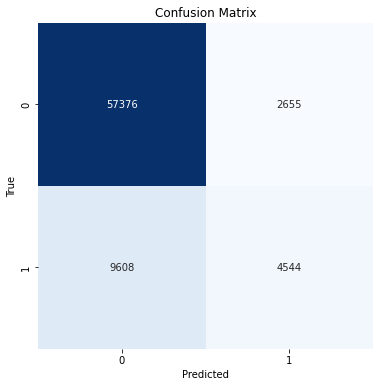

In [52]:
confusion = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

C:\Users\DAytkali\AppData\Local\Temp/ipykernel_10564/1058719809.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(x_train, y_train)


Feature: 0, Score: 0.35318
Feature: 1, Score: 0.07942
Feature: 2, Score: 0.01050
Feature: 3, Score: 0.02426
Feature: 4, Score: 0.02742
Feature: 5, Score: 0.16904
Feature: 6, Score: 0.11374
Feature: 7, Score: 0.07387
Feature: 8, Score: 0.14858
feature: AGE, importance: 0.35318273921992593
feature: CHILDREN_CNT, importance: 0.07941552587149978
feature: IS_CAR_FLG, importance: 0.010495382657592882
feature: EDUCATION_Высшее, importance: 0.02426455016377676
feature: ADD_INCOME_AMT_>=90000, importance: 0.027417952380603593
feature: CLIENT_INCOME_AMT_>=260000, importance: 0.16904160839235108
feature: CARD_CUR_CNT_>=2, importance: 0.11373663531352056
feature: MAX_CREDIT_REST_HY2_>=86000, importance: 0.07386580734347527
feature: CUR_CREDIT_AMT_>=350000, importance: 0.1485797986572542


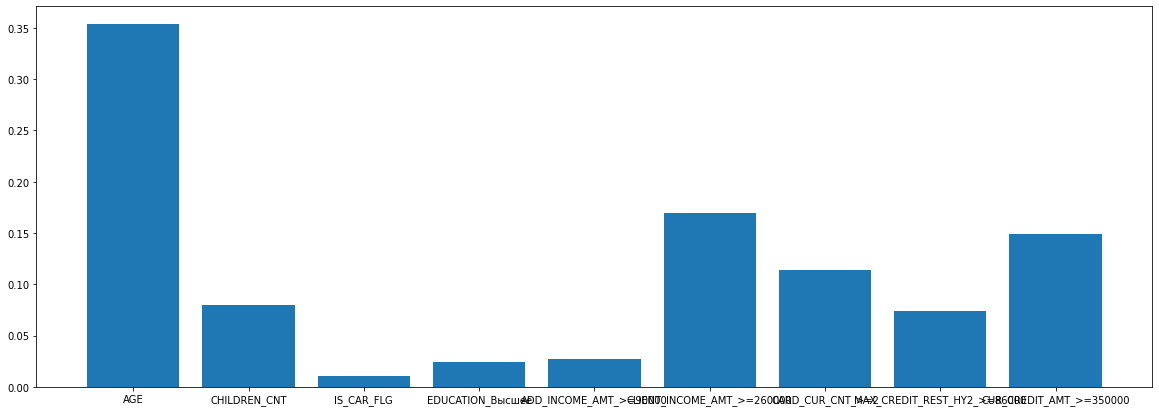

In [205]:
model = RandomForestClassifier()

model.fit(x_train, y_train)

f_importance = model.feature_importances_

for i,v in enumerate(f_importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
    
for feat, importance in zip(x_train.columns, model.feature_importances_):
    print('feature: {f}, importance: {i}'.format(f=feat, i=importance))

fig = plt.figure(figsize =(20, 7))

plt.bar([x for x in x_train.columns], f_importance)
plt.show()

In [206]:
dt_clf = XGBClassifier()
dt_clf.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

Train

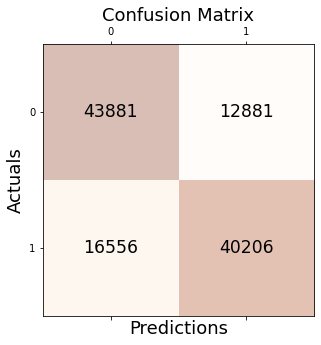

Precision: 0.757
Recall: 0.708
Accuracy: 0.741
F1 Score: 0.732


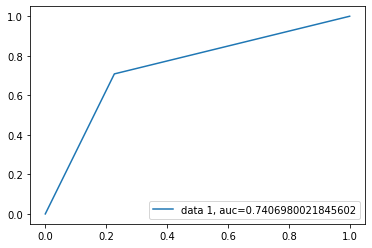

In [207]:
y_train_pred = dt_clf.predict(x_train)

conf_matrix = confusion_matrix(y_true=y_train, y_pred=y_train_pred) 
fig, ax = plt.subplots(figsize=(5, 5)) 
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3) 

for i in range(conf_matrix.shape[0]): 
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large') 
        
plt.xlabel('Predictions', fontsize=18) 
plt.ylabel('Actuals', fontsize=18) 
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print('Precision: %.3f' % precision_score(y_train, y_train_pred))
print('Recall: %.3f' % recall_score(y_train, y_train_pred))
print('Accuracy: %.3f' % accuracy_score(y_train, y_train_pred))
print('F1 Score: %.3f' % f1_score(y_train, y_train_pred))

fpr, tpr, _ = metrics.roc_curve(y_train,  y_train_pred)
auc = metrics.roc_auc_score(y_train, y_train_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

Test

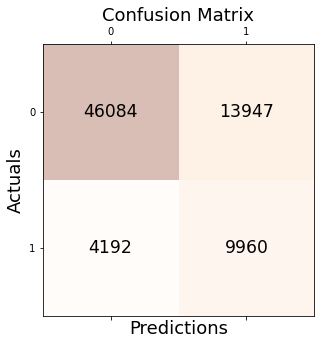

Precision: 0.417
Recall: 0.704
Accuracy: 0.755
F1 Score: 0.523


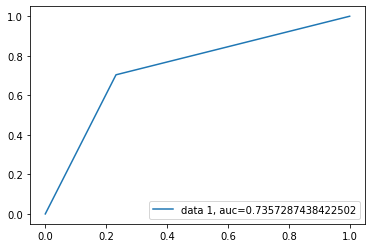

In [208]:
y_test_pred = dt_clf.predict(x_test)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_test_pred) 
fig, ax = plt.subplots(figsize=(5, 5)) 
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)

for i in range(conf_matrix.shape[0]): 
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large') 
        
plt.xlabel('Predictions', fontsize=18) 
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

print('Precision: %.3f' % precision_score(y_test, y_test_pred))
print('Recall: %.3f' % recall_score(y_test, y_test_pred))
print('Accuracy: %.3f' % accuracy_score(y_test, y_test_pred))
print('F1 Score: %.3f' % f1_score(y_test, y_test_pred))

fpr, tpr, _ = metrics.roc_curve(y_test,  y_test_pred)
auc = metrics.roc_auc_score(y_test, y_test_pred)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 56762, number of negative: 56762
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 85
[LightGBM] [Info] Number of data points in the train set: 113524, number of used features: 8
[LightGBM] [Info] Using GOSS
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt

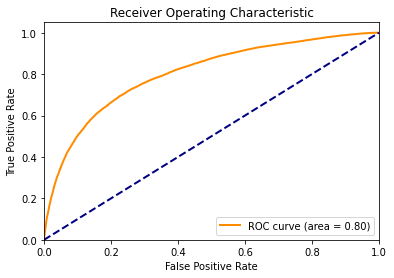

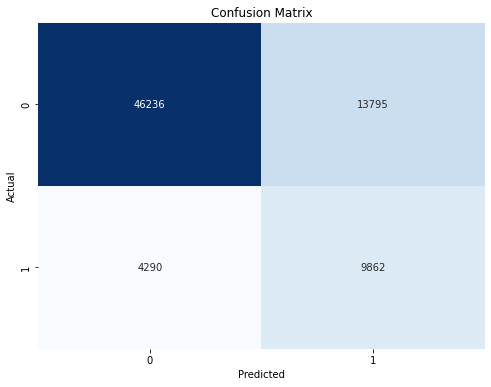

Accuracy: 0.7562
Recall: 0.6969
Precision: 0.4169
F1-Score: 0.5217


In [8]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import RandomUnderSampler
import lightgbm as lgb
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

X = df.drop('Target',axis=1)
y = df[['Target']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rus = RandomUnderSampler(random_state=42)
x_res, y_res = rus.fit_resample(X_train, y_train)
x_res.index = X_train.index[rus.sample_indices_]
y_res.index = y_train.index[rus.sample_indices_]

X_train = x_res
y_train = y_res

# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Define LightGBM parameters
params = {
    'objective': 'binary',
    'metric': 'auc',  # You can change this metric
    'boosting_type': 'goss',
    'num_leaves': 60,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the LightGBM model
num_round = 500
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

# Predict on the test set
y_pred_prob = bst.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Plot ROC-AUC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")


In [44]:
from sklearn.inspection import permutation_importance

baseline_accuracy = accuracy_score(y_test, y_pred)
feature_importances = []

for feature in X_test.columns:
    X_permuted = X_test.copy()
    X_permuted[feature] = X_permuted[feature].sample(frac=1, replace=False).reset_index(drop=True)
    y_pred_permuted = (bst.predict(X_permuted) > 0.5).astype(int)
    permuted_accuracy = accuracy_score(y_test, y_pred_permuted)
    feature_importance = baseline_accuracy - permuted_accuracy
    feature_importances.append((feature, feature_importance))

# Sort and display feature importances
feature_importances.sort(key = lambda x: x[1], reverse=True)
for feature, importance in feature_importances:
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Feature: AGE, Importance: 0.3515
Feature: ADD_INCOME_AMT_>=90000, Importance: 0.0072
Feature: CARD_CUR_CNT_>=2, Importance: -0.0054
Feature: CUR_CREDIT_AMT_>=350000, Importance: -0.0064
Feature: EDUCATION_Высшее, Importance: -0.0087
Feature: CHILDREN_CNT, Importance: -0.0103
Feature: MAX_CREDIT_REST_HY2_>=86000, Importance: -0.0208
Feature: CLIENT_INCOME_AMT_>=260000, Importance: -0.0330


In [3]:
df.loc[((df['AGE']>=75) ,'AGE')]=75
df.loc[((df['AGE']<=18) ,'AGE')]=18

In [15]:
df1 = df.copy()

#df1['TR_LAST_SMBANK_DAYS_CNT'] = np.ceil(df1['TR_LAST_SMBANK_DAYS_CNT'])
#df1 = divide_by_steps(df1, 'TR_LAST_SMBANK_DAYS_CNT', step = 30, aftermax = 360)

#df1.loc[((df1['TR_SMBANK_OPER_CNT_HY2']<0) ,'TR_SMBANK_OPER_CNT_HY2')]=0
#df1 = divide_by_steps(df1, 'TR_SMBANK_OPER_CNT_HY2', step = 50, aftermax = 300)

In [17]:
subset = df1.reset_index()
subset.pivot_table(index='CUR_CREDIT_AMT', columns = 'Target', values = 'CLIENT_ID', aggfunc = 'count')

Target,0,1
CUR_CREDIT_AMT,,
-79640.92,1.0,NaN
-50480.00,1.0,NaN
-25875.00,1.0,NaN
-16094.00,NaN,1.0
-10610.00,1.0,NaN
...,...,...
36644093.89,NaN,1.0
36845255.05,1.0,NaN
38127793.49,1.0,NaN


Information value of CARD_CUR_CNT is 0.287
       Variable         Cutoff       N  Events       WoE        IV
0  CARD_CUR_CNT  (-0.001, 1.0]  344201   56547 -0.184372  0.029766
1  CARD_CUR_CNT   (1.0, 171.0]   26713   14367  1.593916  0.257329


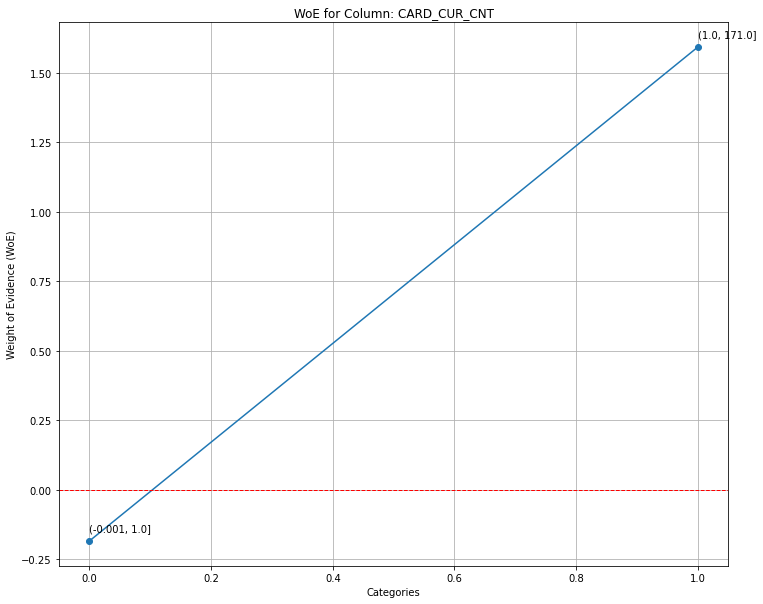

In [24]:
plot_woe(df1, bins = 5, column = 'CARD_CUR_CNT')

In [45]:
# Calculate feature importance using 'gain'
gain_importance = bst.feature_importance(importance_type='gain')
gain_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Gain_Importance': gain_importance})
gain_importance_df = gain_importance_df.sort_values(by='Gain_Importance', ascending=False)

print("Feature Importance based on Gain:")
print(gain_importance_df)

# Calculate feature importance using 'split'
split_importance = bst.feature_importance(importance_type='split')
split_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Split_Importance': split_importance})
split_importance_df = split_importance_df.sort_values(by='Split_Importance', ascending=False)

print("\nFeature Importance based on Split:")
print(split_importance_df)

Feature Importance based on Gain:
                       Feature  Gain_Importance
0                          AGE    265939.792236
4   CLIENT_INCOME_AMT_>=260000    130538.365957
1                 CHILDREN_CNT     95424.586272
7      CUR_CREDIT_AMT_>=350000     90136.107076
5             CARD_CUR_CNT_>=2     73260.984226
6  MAX_CREDIT_REST_HY2_>=86000     46694.044211
2             EDUCATION_Высшее     37971.236692
3       ADD_INCOME_AMT_>=90000     32440.765569

Feature Importance based on Split:
                       Feature  Split_Importance
0                          AGE             12256
1                 CHILDREN_CNT              5430
2             EDUCATION_Высшее              2351
3       ADD_INCOME_AMT_>=90000              2187
6  MAX_CREDIT_REST_HY2_>=86000              1986
4   CLIENT_INCOME_AMT_>=260000              1879
7      CUR_CREDIT_AMT_>=350000              1764
5             CARD_CUR_CNT_>=2              1647


# Test Results Checking

In [24]:
x_test.shape

(11197, 8)

In [25]:
export = x_test.sample(10000)

export_pred_proba = dt_clf.predict_proba(export)[::,1]
export_pred_proba_df = pd.DataFrame(export_pred_proba)

final_ex = pd.merge(export, y_test, left_index=True, right_index=True)
final_ex = final_ex.reset_index()
final_ex = pd.merge(final_ex, export_pred_proba_df, left_index=True, right_index=True)
final_ex.rename(columns = {0:'Score'}, inplace = True)

data = final_ex[['CLIENT_ID', 'Target', 'Score']]

final_df = data.sort_values(by=['Score'], ascending=False)
final_df.to_csv('ABT_PROD_CLF_test_tesults.csv', encoding='utf-8', index = False)

In [62]:
data['Target'].value_counts()

1    5062
0    4938
Name: Target, dtype: int64

# Model Checking on past data

In [21]:
df.columns

Index(['Target', 'AGE', 'CHILDREN_CNT', 'EDUCATION_Высшее',
       'ADD_INCOME_AMT_>=90000', 'CLIENT_INCOME_AMT_>=260000',
       'CARD_CUR_CNT_>=2', 'MAX_CREDIT_REST_HY2_>=86000',
       'CUR_CREDIT_AMT_>=350000'],
      dtype='object')

In [22]:
df.head()

,Target,AGE,CHILDREN_CNT,EDUCATION_Высшее,ADD_INCOME_AMT_>=90000,CLIENT_INCOME_AMT_>=260000,CARD_CUR_CNT_>=2,MAX_CREDIT_REST_HY2_>=86000,CUR_CREDIT_AMT_>=350000
CLIENT_ID,,,,,,,,,
9529273,1,63.0,0.0,1,1,1,0,0,0
9529343,1,47.0,0.0,1,1,1,0,0,0
9529374,1,34.0,0.0,1,1,1,0,0,0
9529498,1,48.0,0.0,1,1,1,1,0,1
9529576,1,62.0,0.0,1,0,0,1,1,0


In [25]:
dataset = pd.read_csv(r'C:\Users\DAytkali\Desktop\ABT_PROD\ABT_PROD_VALIDATION_DATASET.csv', sep=';', encoding = 'mbcs')

dataset = df_transformation(dataset)

dataset = dataset.set_index('CLIENT_ID')

dataset = dataset[df.drop(['Target'], axis = 1).columns]

dataset.fillna(0, inplace = True)

dataset_pred_proba = bst.predict(dataset)

for i in dataset.columns:
    print(i)

dataset = dataset.reset_index()
dataset_pred_proba_df = pd.DataFrame(dataset_pred_proba)

final = pd.merge(dataset, dataset_pred_proba_df, left_index=True, right_index=True)
final.rename(columns = {0:'Score'}, inplace = True)

data = final[['CLIENT_ID', 'Score']]
sorted_df = data.sort_values(by=['Score'], ascending=False)
#final_df = sorted_df[sorted_df['Score']>=0.7]
sorted_df.to_csv('ABT_PROD_validation_scores.csv', encoding='utf-8')

AGE
CHILDREN_CNT
EDUCATION_Высшее
ADD_INCOME_AMT_>=90000
CLIENT_INCOME_AMT_>=260000
CARD_CUR_CNT_>=2
MAX_CREDIT_REST_HY2_>=86000
CUR_CREDIT_AMT_>=350000


In [26]:
df

,Target,AGE,CHILDREN_CNT,EDUCATION,CLIENT_INCOME_AMT,IS_CAR_FLG,ADD_INCOME_AMT,CARD_CUR_CNT,REMN_PAYMENT_CNT,LOAN_DAY_CNT,LAST_CRD_OPEN_MNTH_CNT,TR_MBANLOG_CNT_Q2,MAX_CREDIT_REST_HY2,CUR_DEP_AMT,CUR_CREDIT_AMT
CLIENT_ID,,,,,,,,,,,,,,,
9529273,1,63.0,0.0,Высшее,786780.0,N,155000.0,0,0.0,3481.0,NaN,0,0.0,0.0,0.00
9529343,1,47.0,0.0,Высшее,650000.0,N,400000.0,0,0.0,1278.0,42.0,0,0.0,0.0,0.00
9529374,1,34.0,0.0,Высшее,8714983.0,Y,7864983.0,0,0.0,2168.0,119.0,8,0.0,NaN,0.00
9529498,1,48.0,0.0,Высшее,784686.0,Y,264686.0,2,64.0,177.0,6.0,0,0.0,NaN,4298330.22
9529576,1,62.0,0.0,Высшее,150000.0,Y,0.0,2,11.0,47.0,0.0,0,314900.0,NaN,54032.69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63108175,0,NaN,NaN,NaN,NaN,N,NaN,1,59.0,0.0,11.0,0,3687901.0,NaN,3676828.05
63108205,0,NaN,NaN,NaN,NaN,N,NaN,0,0.0,412.0,NaN,0,795000.0,NaN,0.00
63108373,0,NaN,NaN,NaN,NaN,N,NaN,0,0.0,439.0,NaN,0,422880.0,NaN,0.00


# Get Current Scores

In [11]:
dataset.columns

Index(['CLIENT_ID', 'AGE', 'CHILDREN_CNT', 'EDUCATION', 'CLIENT_INCOME_AMT',
       'IS_CAR_FLG', 'ADD_INCOME_AMT', 'TR_MBANLOG_CNT_Q2', 'REMN_PAYMENT_CNT',
       'LOAN_DAY_CNT', 'CARD_CUR_CNT', 'MAX_CREDIT_REST_HY2', 'CUR_DEP_AMT',
       'CUR_CREDIT_AMT'],
      dtype='object')

In [40]:
dataset = pd.read_csv(r'C:\Users\DAytkali\Desktop\ABT_PROD\ABT_PROD_UPLOAD_DATASET.csv', sep=';', encoding = 'mbcs')

dataset = df_transformation(dataset)

dataset = dataset.set_index('CLIENT_ID')

dataset = dataset[df.drop(['Target'], axis = 1).columns]

dataset.fillna(0, inplace = True)

dataset_pred_proba = bst.predict(dataset)

for i in dataset.columns:
    print(i)

dataset = dataset.reset_index()
dataset_pred_proba_df = pd.DataFrame(dataset_pred_proba)

final = pd.merge(dataset, dataset_pred_proba_df, left_index=True, right_index=True)
final.rename(columns = {0:'Score'}, inplace = True)

data = final[['CLIENT_ID', 'Score']]
sorted_df = data.sort_values(by=['Score'], ascending=False)
#final_df = sorted_df[sorted_df['Score']>=0.7]
sorted_df.to_csv('ABT_PROD_upload_scores.csv', encoding='utf-8')

AGE
CHILDREN_CNT
EDUCATION_Высшее
ADD_INCOME_AMT_>=90000
CLIENT_INCOME_AMT_>=260000
CARD_CUR_CNT_>=2
MAX_CREDIT_REST_HY2_>=86000
CUR_CREDIT_AMT_>=350000


In [37]:
dataset.head()

,CLIENT_ID,Target,AGE,CHILDREN_CNT,EDUCATION_Высшее,ADD_INCOME_AMT_>=90000,CLIENT_INCOME_AMT_>=260000,CARD_CUR_CNT_>=2,MAX_CREDIT_REST_HY2_>=86000,CUR_CREDIT_AMT_>=350000
0,9529263,1,53.0,1.0,0,0,0,0,0,0
1,9529264,1,36.0,0.0,1,1,1,0,0,0
2,9529265,1,44.0,0.0,0,1,1,0,0,0
3,9529266,1,50.0,0.0,1,1,1,0,0,0
4,9529267,1,43.0,1.0,1,0,0,0,0,0
